In [42]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.feature_selection import VarianceThreshold





In [43]:
price, listings, reviews = load_data_cleansed_imputed()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:54: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:84: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  fil = listings["host_location"].str.contains(i, case = False, na = False)
/Users/dmn

Data is cleansed. Now start the imputation.
Imputation done. No NaN's are left in the data.
Have fun implementing your models.


# Data format modification

We will ignore all text columns for now. So filter them out:

In [44]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]
listings = listings.drop(text_col, axis = 1)

Facing the NAs of the data, we observe that there are many missing values

In [45]:
na_values = listings.isna().sum().sort_values()
na_values.where(na_values > 100).dropna()

Series([], dtype: float64)

All review variables are problematic. Let's drop all of them for now

In [46]:
na_filter = listings.isna().any(axis = 1)
listings = listings[~na_filter]
price = price[~na_filter]
listings = listings.reset_index(drop = True)
listings.head()


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Dates

Now let's deal with the date columns and turn them into numbers which give the difference to the last_scraped date

In [47]:
print(type(listings["last_scraped"][2]))
print(type(pd.to_datetime(listings["last_scraped"])[2]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


we have to turn every string into a datetime object

In [48]:
date_col = ["last_scraped","host_since","first_review", "last_review"]

pd.to_datetime(listings["last_scraped"], yearfirst = True)

0      2021-11-08
1      2021-11-08
2      2021-11-08
3      2021-11-08
4      2021-11-08
          ...    
6835   2021-11-08
6836   2021-11-08
6837   2021-11-08
6838   2021-11-08
6839   2021-11-08
Name: last_scraped, Length: 6840, dtype: datetime64[ns]

In [49]:
date_df = listings.filter(date_col).apply(pd.to_datetime)

In [50]:
date_df.head()

last_scraped host_since first_review last_review
0   2021-11-08 2010-08-06   2011-08-18  2020-02-08
1   2021-11-08 2010-08-06   2014-11-24  2020-02-09
2   2021-11-08 2011-07-01   2014-05-20  2019-12-21
3   2021-11-08 2011-07-04   2015-07-18  2020-02-09
4   2021-11-08 2011-07-07   2016-12-04  2017-01-25

Now we can calculate the time delta

In [51]:
date_df["last_scraped"]-date_df["first_review"]

0      3735 days
1      2541 days
2      2729 days
3      2305 days
4      1800 days
          ...   
6835      0 days
6836      0 days
6837      0 days
6838      0 days
6839      0 days
Length: 6840, dtype: timedelta64[ns]

In [52]:
listings["host_since"] = date_df["last_scraped"]-date_df["host_since"]
listings["first_review"] = date_df["last_scraped"]-date_df["first_review"]
listings["last_review"] = date_df["last_scraped"]-date_df["last_review"]

In [53]:
listings.filter(date_col).head()

last_scraped host_since first_review last_review
0   2021-11-08  4112 days    3735 days    639 days
1   2021-11-08  4112 days    2541 days    638 days
2   2021-11-08  3783 days    2729 days    688 days
3   2021-11-08  3780 days    2305 days    638 days
4   2021-11-08  3777 days    1800 days   1748 days

We don't use the last_scraped column any longer

In [54]:
listings = listings.drop("last_scraped", axis = 1)

We have a timedelta object in each cell now. We should convert it into an integer using its attribute .days

In [55]:
date_col = date_col[1:]
for i in date_col:
    listings[i] = pd.Series([j.days for j in list(listings[i])])


In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## Categories

Next we have to create dummies for the categorical variables in order to use them for models like RandomForests, Ridge,...

In [57]:
listings.head()

host_since  host_listings_count neighbourhood_cleansed  latitude  \
0        4112                  3.0  Dn Laoghaire-Rathdown  53.29178   
1        4112                  3.0  Dn Laoghaire-Rathdown  53.29209   
2        3783                  0.0            Dublin City  53.39027   
3        3780                  2.0  Dn Laoghaire-Rathdown  53.28326   
4        3777                  5.0            Dublin City  53.33744   

   longitude                     property_type        room_type  accommodates  \
0   -6.25792          Private room in bungalow     Private room             2   
1   -6.25624          Private room in bungalow     Private room             2   
2   -6.23547  Private room in residential home     Private room             1   
3   -6.19188         Private room in townhouse     Private room             6   
4   -6.32363                Entire rental unit  Entire home/apt             5   

   beds  minimum_nights  maximum_nights  availability_30  availability_60  \
0   2.0               3            1125                0                0   
1   1.0               3              21                0                0   
2   1.0               2              21                5               17   
3   4.0               1              12                6                8   
4   3.0               4             365               11               18   

   availability_90  availability_365  number_of_reviews  \
0               22               202                227   
1               21               296                182   
2               35               310                313   
3               31               106                288   
4               41               283                 50   

   number_of_reviews_ltm  number_of_reviews_l30d  first_review  last_review  \
0                      0                       0          3735          639   
1                      0                       0          2541          638   
2                      2                       1          2729          688   
3                      4                       1          2305          638   
4                      7                       1          1800         1748   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.77                    4.82                       4.72   
1                  4.79                    4.85                       4.72   
2                  4.75                    4.76                       4.72   
3                  4.83                    4.87                       4.84   
4                  4.56                    4.86                       4.68   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.92                    4.66                 4.82   
1                         4.88                    4.66                 4.80   
2                         4.90                    4.62                 4.74   
3                         4.97                    4.77                 4.84   
4                         4.72                    4.30                 4.46   

   calculated_host_listings_count  reviews_per_month host_location_country  \
0                               3               1.82               Ireland   
1                               3               2.15               Ireland   
2                               3               3.44               Ireland   
3                               2               3.75               Ireland   
4                               5               0.83               Ireland   

  bath_kind  Bathtub  Bed linens  Breakfast  Cleaning before checkout  \
0    Shared      1.0         1.0        1.0                       0.0   
1    Shared      0.0         0.0        1.0                       0.0   
2    Shared      0.0         1.0        1.0                       0.0   
3    Shared      0.0         0.0        0.0                       0.0   
4    Normal      0

In [58]:
cat_col = ["neighbourhood_cleansed", "property_type", "room_type", "host_location_country", "bath_kind"]


Best approach might be to convert all categories into dummy_variables. Let's see how man categories there are for each variables

In [59]:
for i in cat_col:
    print(listings[i].value_counts())

Dublin City              5206
Dn Laoghaire-Rathdown     732
Fingal                    624
South Dublin              278
Name: neighbourhood_cleansed, dtype: int64
Entire rental unit                     1592
Private room in rental unit            1392
Private room in residential home       1344
Entire residential home                 927
Entire condominium (condo)              269
Private room in townhouse               240
Entire townhouse                        219
Others                                  186
Private room in condominium (condo)     159
Entire serviced apartment                95
Private room in bed and breakfast        88
Entire guest suite                       48
Entire cottage                           46
Private room in bungalow                 44
Entire guesthouse                        33
Entire loft                              28
Entire bungalow                          26
Entire cabin                             19
Private room in guest suite              18
P

That looks fine. Let's define a function that sets up the dummies and drops the category column:

In [60]:
def to_dummy_single(df, X, output_name):
    dummies = pd.get_dummies(df[X])
    dummies.columns = output_name + "_" + dummies.columns

    if len(dummies.columns) == 2:
        dummies = dummies[dummies.columns[0]]

    df = df.join(dummies)
    df = df.drop(X, axis = 1)

    return df

def to_dummy(df, X_list, output_names):
    for i in range(len(X_list)):
        df = to_dummy_single(df, X_list[i], output_names[i])
    
    return df



In [61]:
listings = to_dummy(listings, cat_col, cat_col)
listings.head()

host_since  host_listings_count  latitude  longitude  accommodates  beds  \
0        4112                  3.0  53.29178   -6.25792             2   2.0   
1        4112                  3.0  53.29209   -6.25624             2   1.0   
2        3783                  0.0  53.39027   -6.23547             1   1.0   
3        3780                  2.0  53.28326   -6.19188             6   4.0   
4        3777                  5.0  53.33744   -6.32363             5   3.0   

   minimum_nights  maximum_nights  availability_30  availability_60  \
0               3            1125                0                0   
1               3              21                0                0   
2               2              21                5               17   
3               1              12                6                8   
4               4             365               11               18   

   availability_90  availability_365  number_of_reviews  \
0               22               202                227   
1               21               296                182   
2               35               310                313   
3               31               106                288   
4               41               283                 50   

   number_of_reviews_ltm  number_of_reviews_l30d  first_review  last_review  \
0                      0                       0          3735          639   
1                      0                       0          2541          638   
2                      2                       1          2729          688   
3                      4                       1          2305          638   
4                      7                       1          1800         1748   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.77                    4.82                       4.72   
1                  4.79                    4.85                       4.72   
2                  4.75                    4.76                       4.72   
3                  4.83                    4.87                       4.84   
4                  4.56                    4.86                       4.68   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.92                    4.66                 4.82   
1                         4.88                    4.66                 4.80   
2                         4.90                    4.62                 4.74   
3                         4.97                    4.77                 4.84   
4                         4.72                    4.30                 4.46   

   calculated_host_listings_count  reviews_per_month  Bathtub  Bed linens  \
0                               3               1.82      1.0         1.0   
1                               3               2.15      0.0         0.0   
2                               3               3.44      0.0         1.0   
3                               2               3.75      0.0         0.0   
4                               5               0.83      0.0         0.0   

   Breakfast  Cleaning before checkout  Dishwasher  Elevator  Hair dryer  \
0        1.0                       0.0         1.0       0.0         1.0   
1        1.0                       0.0         1.0       0.0         1.0   
2        1.0                       0.0         1.0       0.0         1.0   
3        0.0                       0.0         0.0       0.0         1.0   
4        0.0                       0.0         1.0       0.0         1.0   

   Indoor fireplace  Long term stays allowed  Private entrance  \
0               1.0                      1.0               0.0   
1               0.0                      0.0               0.0   
2               0.0                      0.0               0.0   
3               1.0                      1.0               0.0   
4               1.0                      1.0               0.0   

   Securit

In [62]:
listings.dtypes

host_since                                int64
host_listings_count                     float64
latitude                                float64
longitude                               float64
accommodates                              int64
                                         ...   
host_location_country_United Kingdom      uint8
host_location_country_United States       uint8
bath_kind_Normal                          uint8
bath_kind_Private                         uint8
bath_kind_Shared                          uint8
Length: 134, dtype: object

seems like we have only numeric data types in our listings. Lets head over to the selection

# Variable Selection



In [63]:
listings.columns[listings.columns.str.contains("bedroom")]

Index(['bedroom_number_1', 'bedroom_number_2', 'bedroom_number_3',
       'bedroom_number_greater3'],
      dtype='object')

In [64]:
price = np.log(price)


In [90]:
liste = (num_col + binary_col)
list(set(listings.columns).difference(liste))

['Game_consoles']

In [88]:
(num_col + binary_col) - list(listings.columns)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [91]:
num_col = ['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month']


binary_col = ['Bathtub', 'Bed linens', 'Breakfast',
       'Cleaning before checkout', 'Dishwasher', 'Elevator', 'Hair dryer',
       'Indoor fireplace', 'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home', 'Oven_available',
       'Stoves_available', 'Refridgerator_available',
       'Body_soap_available', 'Garden_backyard_available',  'Children_Entertainment', 'Workspace',
       'Shampoo_Conditioner_available', 'Fast_wifi_available',
       'Gym_available', 'Coffee_machine_available', 'Dryer_available',
       'Washer_available', 'Hot_tub_available', 'Pool_available',
       'Patio_balcony_available', 'Wifi_available', 'AC_available',
       'heating_available', 'Kitchen_available', 'Safe_available',
       'Water_location','neighbourhood_cleansed_Dn Laoghaire-Rathdown',
       'neighbourhood_cleansed_Dublin City',
       'neighbourhood_cleansed_Fingal',
       'neighbourhood_cleansed_South Dublin',
       'property_type_Entire bungalow', 'property_type_Entire cabin',
       'property_type_Entire condominium (condo)',
       'property_type_Entire cottage', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire loft',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Entire serviced apartment',
       'property_type_Entire townhouse', 'property_type_Others',
       'property_type_Private room',
       'property_type_Private room in bed and breakfast',
       'property_type_Private room in bungalow',
       'property_type_Private room in cabin',
       'property_type_Private room in condominium (condo)',
       'property_type_Private room in cottage',
       'property_type_Private room in guest suite',
       'property_type_Private room in guesthouse',
       'property_type_Private room in rental unit',
       'property_type_Private room in residential home',
       'property_type_Private room in townhouse',
       'property_type_Tiny house', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'host_location_country_Argentina',
       'host_location_country_Australia', 'host_location_country_Belgium',
       'host_location_country_Brazil', 'host_location_country_Bulgaria',
       'host_location_country_Canada', 'host_location_country_Croatia',
       'host_location_country_France', 'host_location_country_Germany',
       'host_location_country_India', 'host_location_country_Ireland',
       'host_location_country_Israel', 'host_location_country_Italy',
       'host_location_country_Mexico',
       'host_location_country_Netherlands',
       'host_location_country_Others', 'host_location_country_Poland',
       'host_location_country_Portugal', 'host_location_country_Spain',
       'host_location_country_Sweden',
       'host_location_country_Switzerland',
       'host_location_country_Turkey',
       'host_location_country_United Kingdom',
       'host_location_country_United States', 'bath_kind_Normal',
       'bath_kind_Private', 'bath_kind_Shared', "TV_available", "sound_system_available",
       'Free_parking', 'Paid_parking', 'Special_stuff', 'Outdoor_stuff',
       'Baby_friendly', 'bath_number_0', 'bath_number_1', 'bath_number_2', 'bath_number_3',
       'bath_number_greater3', 'bedroom_number_1', 'bedroom_number_2', 'bedroom_number_3',
       'bedroom_number_greater3', "Game_consoles"]


In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(listings[num_col])
stand_values = scaler.transform(listings[num_col])
listings[num_col] = stand_values


## Random Forest Model

In [83]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings, price, random_state = 123)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5799298598339379

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


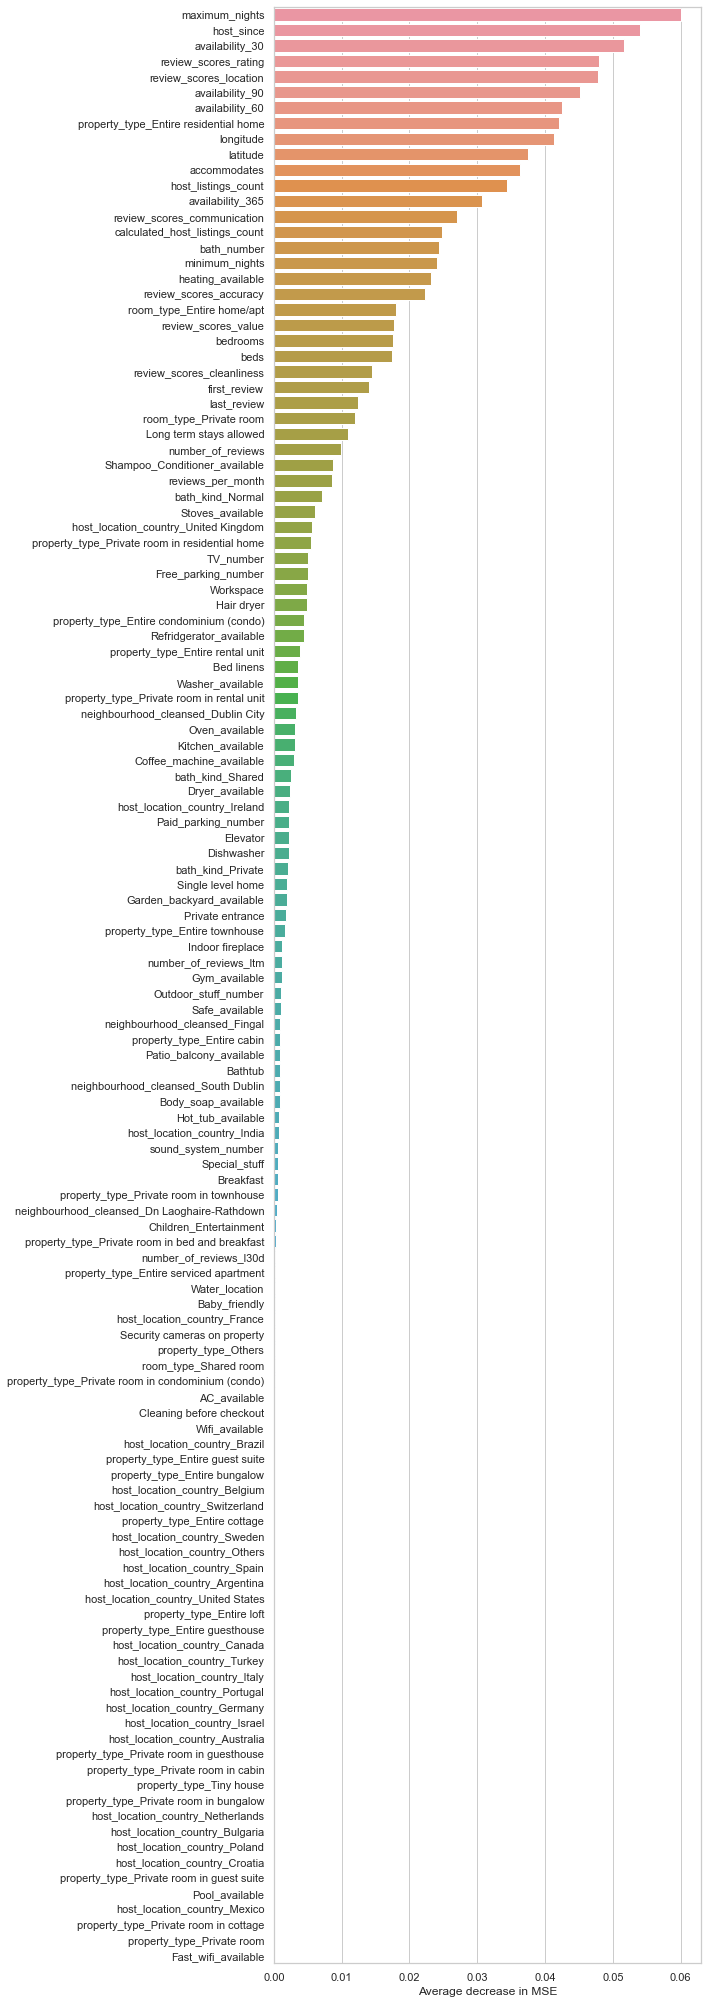

In [25]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation
Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

### Permutation approach

In [26]:
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/1120045921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## Ridge with Kernel model
Let's repeat the permutation approach for several other algorithms

### rbf kernel

In [64]:
# train Ridge Kernel model
rbf_ridge = KernelRidge(kernel = "rbf", alpha = 0)
rbf_ridge.fit(X_train, y_train)
rbf_ridge.score(X_test, y_test)

-28.947508003116944

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_3738/1598192241.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


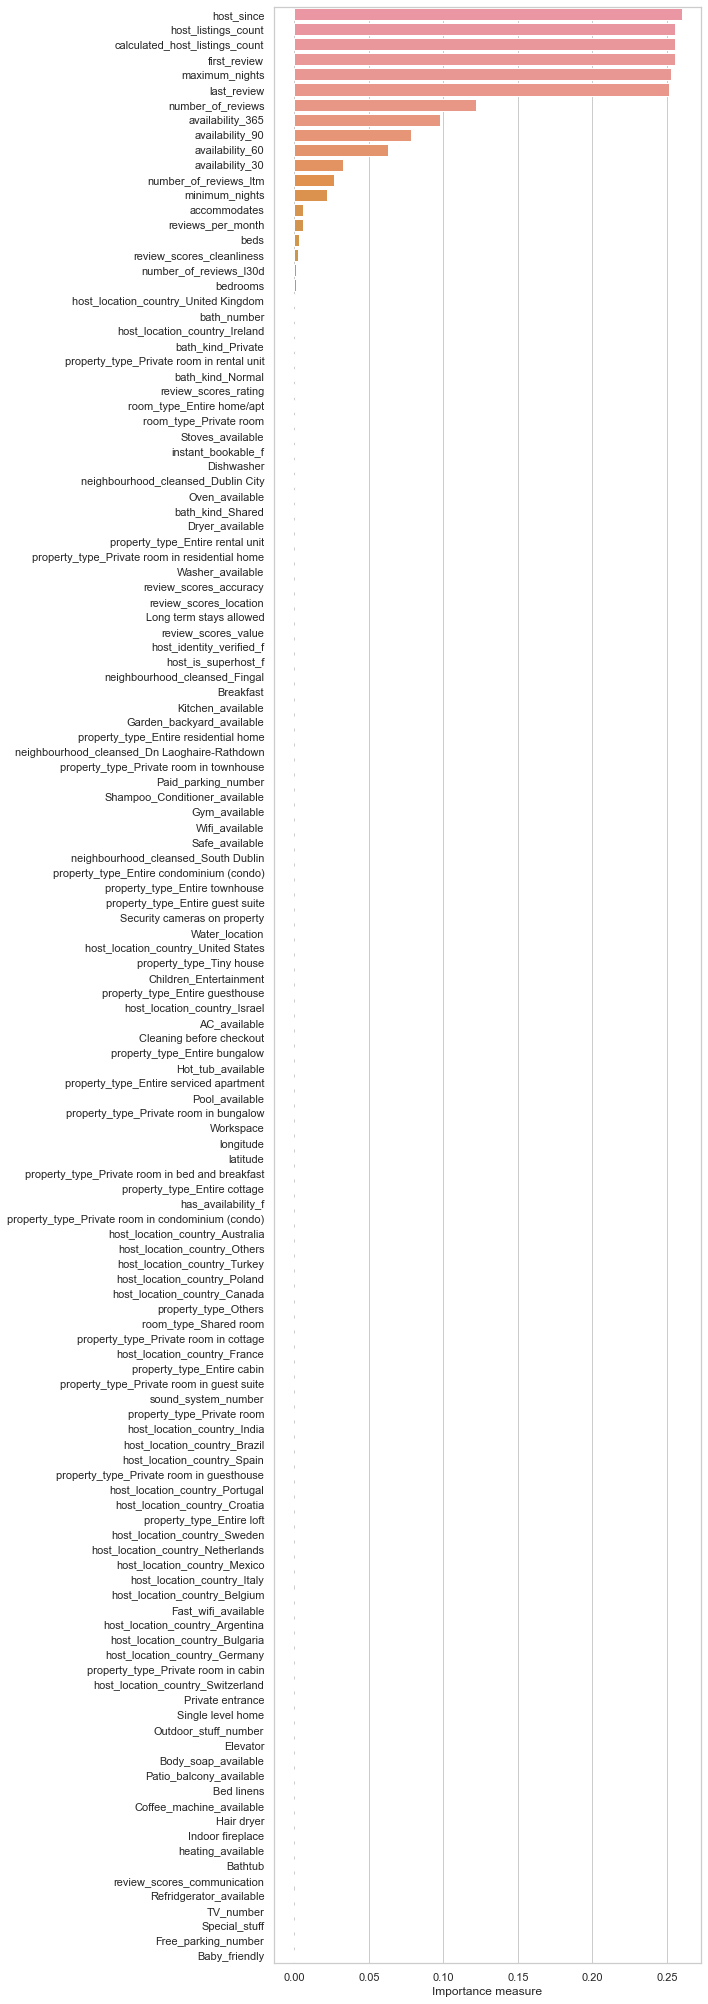

In [27]:
result = permutation_importance(rbf_ridge, X_test, y_test, n_repeats=10, random_state=42)
rbf_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = rbf_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

### linear kernel

In [84]:
# train Ridge Kernel model
linear_ridge = KernelRidge(kernel = "linear")
linear_ridge.fit(X_train, y_train)
linear_ridge.score(X_test, y_test)

-35.59898229706792

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/3969062155.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


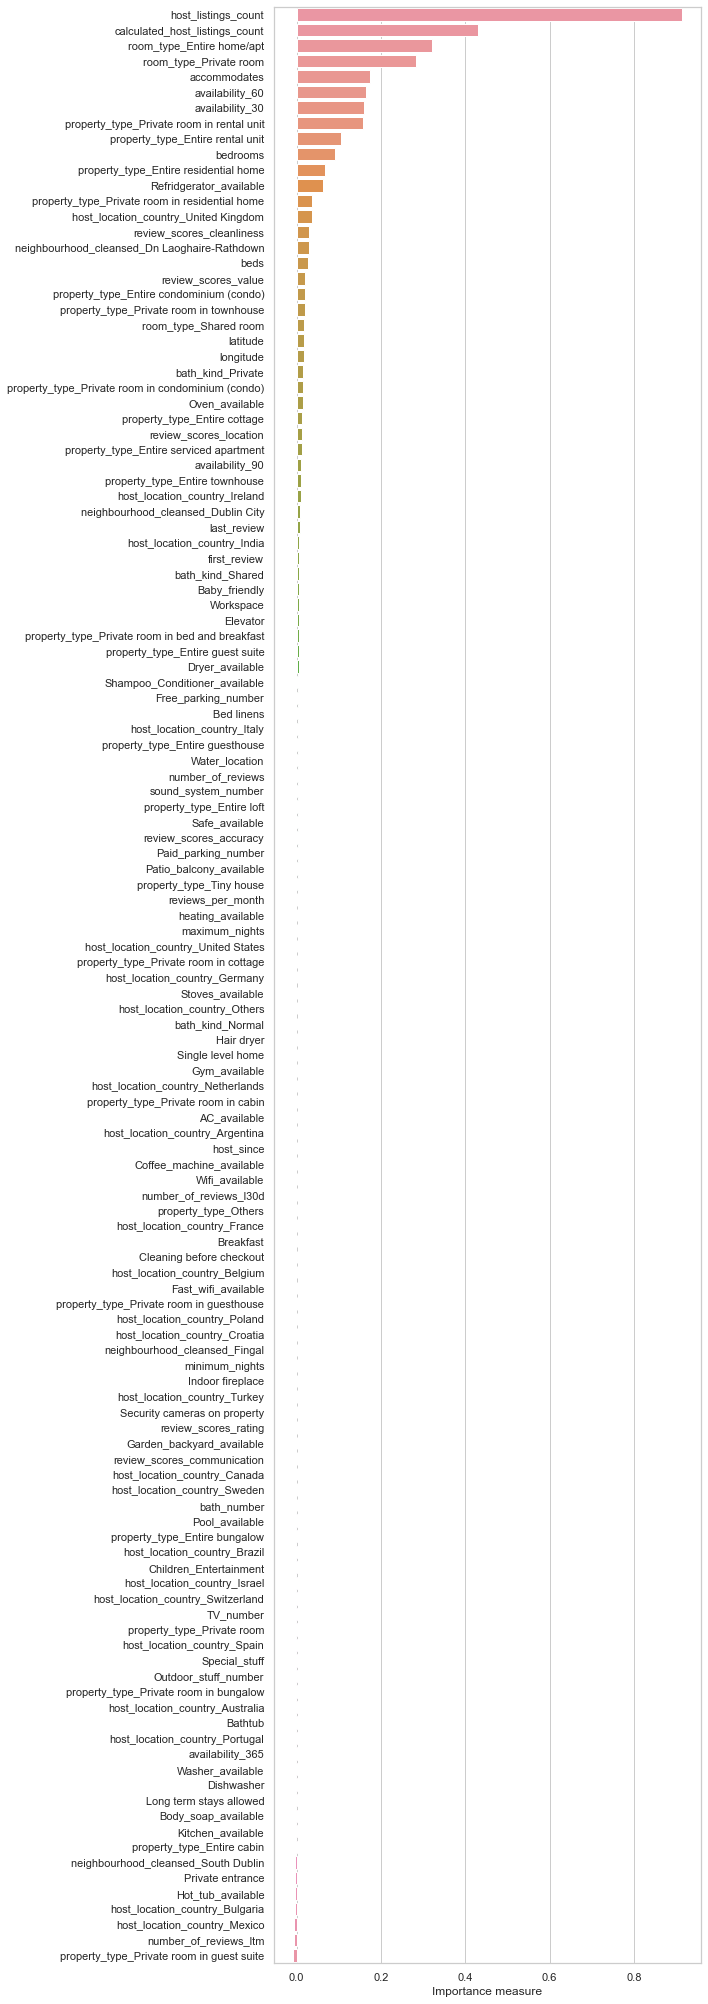

In [85]:
result = permutation_importance(linear_ridge, X_test, y_test, n_repeats=10, random_state=42)
linear_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## SVR
### rbf kernel

In [31]:
# train Ridge Kernel model
rbf_svr= SVR(kernel = "rbf")
rbf_svr.fit(X_train, y_train)
rbf_svr.score(X_test, y_test)

-0.041718898912411095

In [31]:
#result = permutation_importance(rbf_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
#rbf_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
#plot_data = rbf_svr_importances.sort_values(ascending=False)

# plotting
#sn.set_theme(style = "whitegrid")
#fig, ax = plt.subplots(figsize = (10,28))
#sn.barplot(x=plot_data.values, y=plot_data.index)
#ax.set_xlabel("Importance measure")
#fig.tight_layout()
#fig.show()

In [29]:
# train Ridge Kernel model
linear_svr= LinearSVR(max_iter = 100000)
linear_svr.fit(X_train, y_train)
linear_svr.score(X_test, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.06431278932492579

In [33]:
result = permutation_importance(linear_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
linear_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_svr_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_3738/827178593.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## Boosting

In [68]:
params = {
    "n_estimators": 200,
    "max_depth": 2,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

In [69]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.6668833547846216

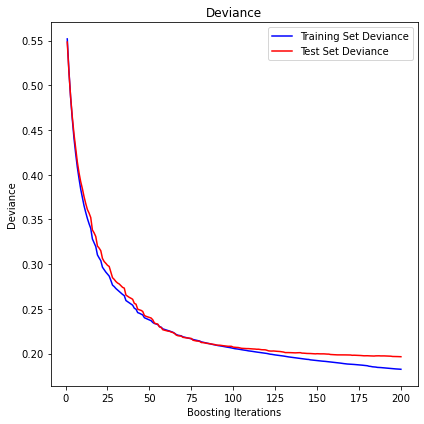

In [70]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

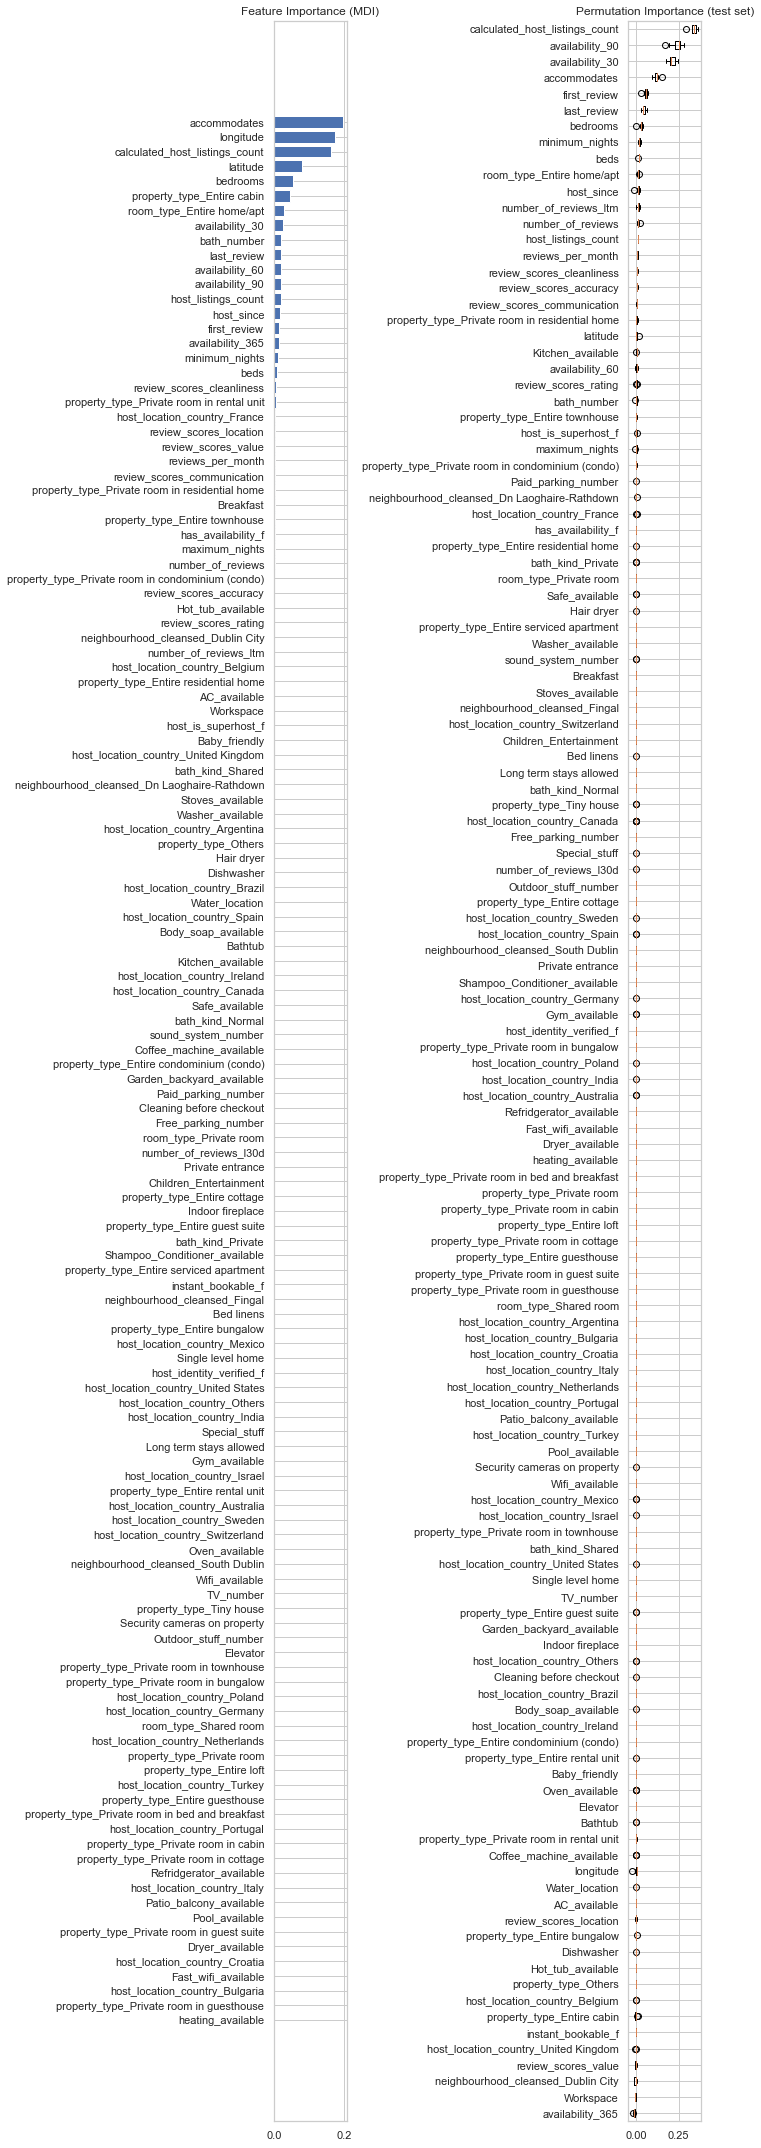

In [37]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(listings.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(listings.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

The problem of this method is that the importance of highly correlated amenities disappears as shuffling the first feature the model could still get the information by the second correlated feature. 
This can be the case for our data. For instance the possibility to stay for a longer time might be highly correlated with the availability of a washing machine or having a kitchen and an oven.

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We should take the correlation of the variables into account. Therefore we need different approaches dependent on the scale of variables
- pearson: numeric and numeric 
- jaccard: binary and binary
- point-biserial: binary and numeric

In [92]:
listings.columns.values

array(['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month', 'Bathtub',
       'Bed linens', 'Breakfast', 'Cleaning before checkout',
       'Dishwasher', 'Elevator', 'Hair dryer', 'Indoor fireplace',
       'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home',
       'Oven_available', 'Stoves_available', 'Refridgerator_available',
       'Body_soap_available', 'Garden_backyard_available', 'Free_parking',
       'Paid_parking

In [93]:
# sanity check
len(num_col + binary_col) == len(listings.columns)

True

## Pearson Correlation

In [94]:
numerical_df = listings.filter(num_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = numerical_df.columns

sel.fit_transform(numerical_df)
num_col = sel.get_feature_names_out()
print(str(len(numerical_df.columns) - len(num_col)) + " variables have been removed")
numerical_df = numerical_df.filter(num_col)

0 variables have been removed


In [95]:
PEARSON = np.abs(numerical_df.corr())

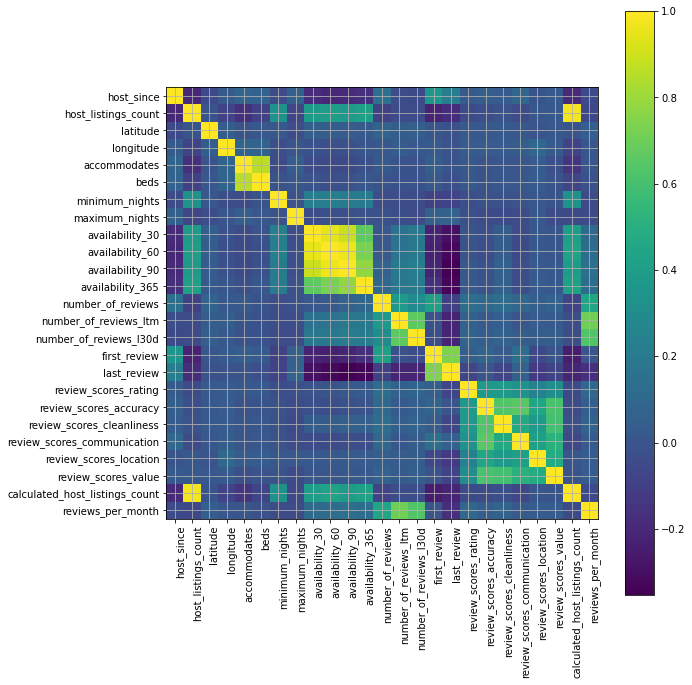

In [96]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(listings.filter(num_col).corr())
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(num_col)), labels=num_col)
ax.set_yticks(np.arange(len(num_col)), labels=num_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()

## Binary Features

Let's remove features which don't have enough variance or in other words which are either 0 or 1 in most of the cases 
- https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f







In [97]:
from sklearn.feature_selection import VarianceThreshold


In [98]:
binary_df = listings.filter(binary_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = binary_df.columns

sel.fit_transform(binary_df)
binary_col = sel.get_feature_names_out()
print(str(len(binary_df.columns) - len(binary_col)) + " variables have been removed")
binary_df = binary_df.filter(binary_col)

68 variables have been removed


### Jaccard Correlation

At first lets define a function that calculates the Jaccard Correlation coefficient

In [99]:
def jac(x,y):
    a = ((x == 1) == (y == 1)).sum()
    b = ((x == 1) == (y == 0)).sum()
    c = ((x == 0) == (y == 1)).sum()
    #d = ((x == 0) == (y == 0)).sum()

    j = a/(a+b+c)

    return j

Now calculate the coefficient for each combination of binary covariables

In [100]:
# init matrix
A = np.zeros((len(binary_col), len(binary_col)))

for i, a in enumerate(binary_col):
    for j, b in enumerate(binary_col):
        A[i,j] = jac(binary_df[a], binary_df[b])


In [101]:
JACCARD = pd.DataFrame(np.abs(A))
jac_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(jac_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(binary_col)), labels=binary_col)
ax.set_yticks(np.arange(len(binary_col)), labels=binary_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary features", fontsize = 35)
fig.tight_layout()
plt.show()

## Point-Biserial

- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

In [102]:
from scipy import stats
binaries = binary_df
numericals = numerical_df

# init matrix
A = np.zeros((len(binaries.columns), len(numericals.columns)))
P = np.zeros((len(binaries.columns), len(numericals.columns)))

for i, a in enumerate(binaries.columns):
    for j, b in enumerate(numericals.columns):
        A[i,j], P[i,j] = stats.pointbiserialr(binaries[a], numericals[b])

    


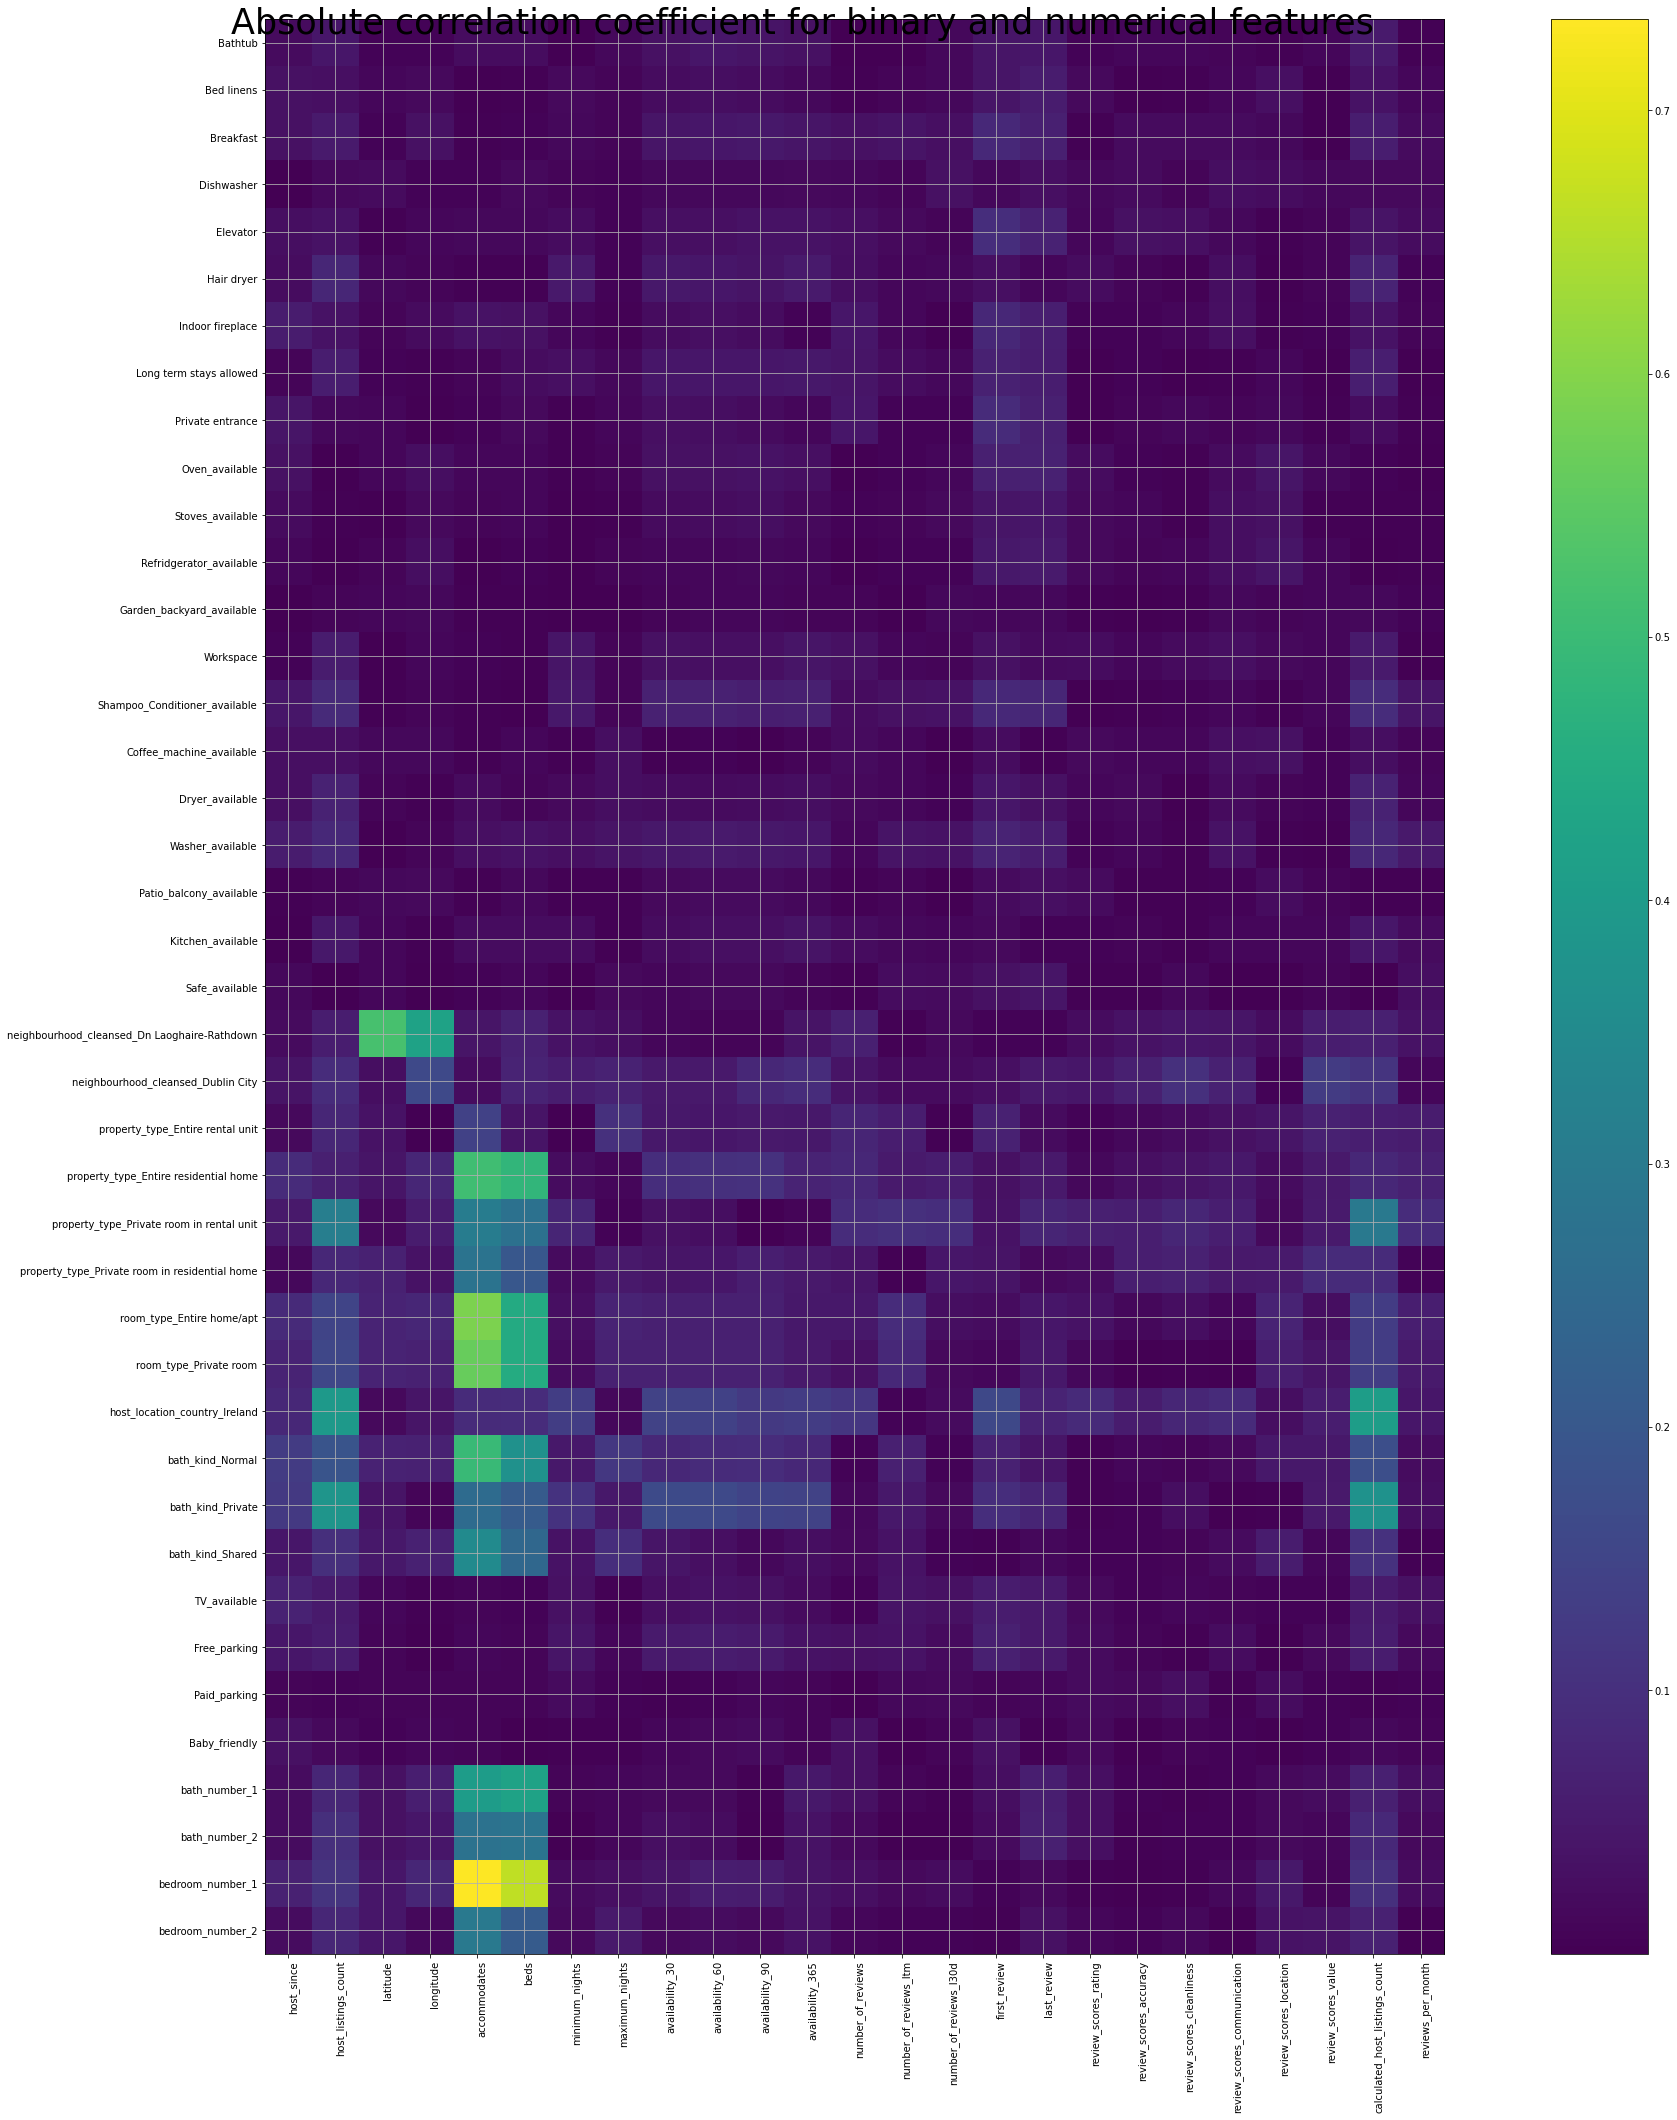

In [103]:
BISERIAL = pd.DataFrame(np.abs(A))
bis_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(bis_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(numericals.columns)), labels=numericals)
ax.set_yticks(np.arange(len(binaries.columns)), labels=binaries)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

## Combine all correlation coefficients in a single matrix

In [104]:
all_col = list(binary_col) + list(num_col)
listings_compl = listings.filter(all_col)
C = np.zeros((len(all_col), len(all_col)))

C[:len(binary_col),:len(binary_col)] = JACCARD
C[len(binary_col):,len(binary_col):] = PEARSON
C[len(binary_col):,:len(binary_col)] = BISERIAL.T
C[:len(binary_col),len(binary_col):] = BISERIAL

C_df = pd.DataFrame(np.abs(C))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(C_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(C_df.columns)), labels=all_col)
ax.set_yticks(np.arange(len(C_df.columns)), labels=all_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

In [105]:

import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr = C
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

The dendrogram shows which features are so similar that it might be reasonable to keep only one of those variables. We can set our threshold around 0.5 and explore the clusters we find below:

### For threshold = 0.5
1. keep room type Entire home/apt
3. keep kitchen available
4. combine to bathroom essentials 
5. combine stove, oven and refridgerator to large kitchen appliances
6. combine patio balcony and garden to outside areas
7. keep room type private room 
8. keep breakfast 
9. keep property type private room in rental unit
10. keep property type entire residential home


In [192]:
listings_compl = drop_col(listings_compl, ["host_location_country_Ireland", "Washer_available", "Bed linens", "Dishwasher", "Coffee_machine_available", 
    "property_type_Private room in residential home", "bath_kind_Shared", "Indoor fireplace", "bath_kind_Private", "Safe_available", 
    "Bathtub", "neighbourhood_cleansed_Dn Laoghaire-Rathdown", "bath_kind_Normal", "bedrooms", "beds","review_scores_accuracy", "review_scores_value", "review_scores_cleanliness",
    "review_scores_communication","host_listings_count", "availability_30", "availability_60", "availability_90", "number_of_reviews_l30d", "number_of_reviews_ltm", "first_review", ""], regex = False)
listings_compl = in_one(listings_compl, "(Shampoo_Conditioner)|(Hair dryer)", "bathroom_essentials", regex = True, sum = True, drop = True)
listings_compl = in_one(listings_compl, "(stoves_)|(oven_)|(refridgerator)", "large_kitchen_appliances", regex = True, sum = True, drop = True)
listings_compl = in_one(listings_compl, "(patio_balcony)|(garden_)", "outside_area_available", regex = True, sum = True, drop = True)

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/helpers.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter = df.columns.str.contains(in_cat, case = False, regex = True)


# Final Selection

## Random Forest Model

In [193]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings_compl, price, random_state = 123, test_size = 0.2)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5769084290917075

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [242]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings_compl.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


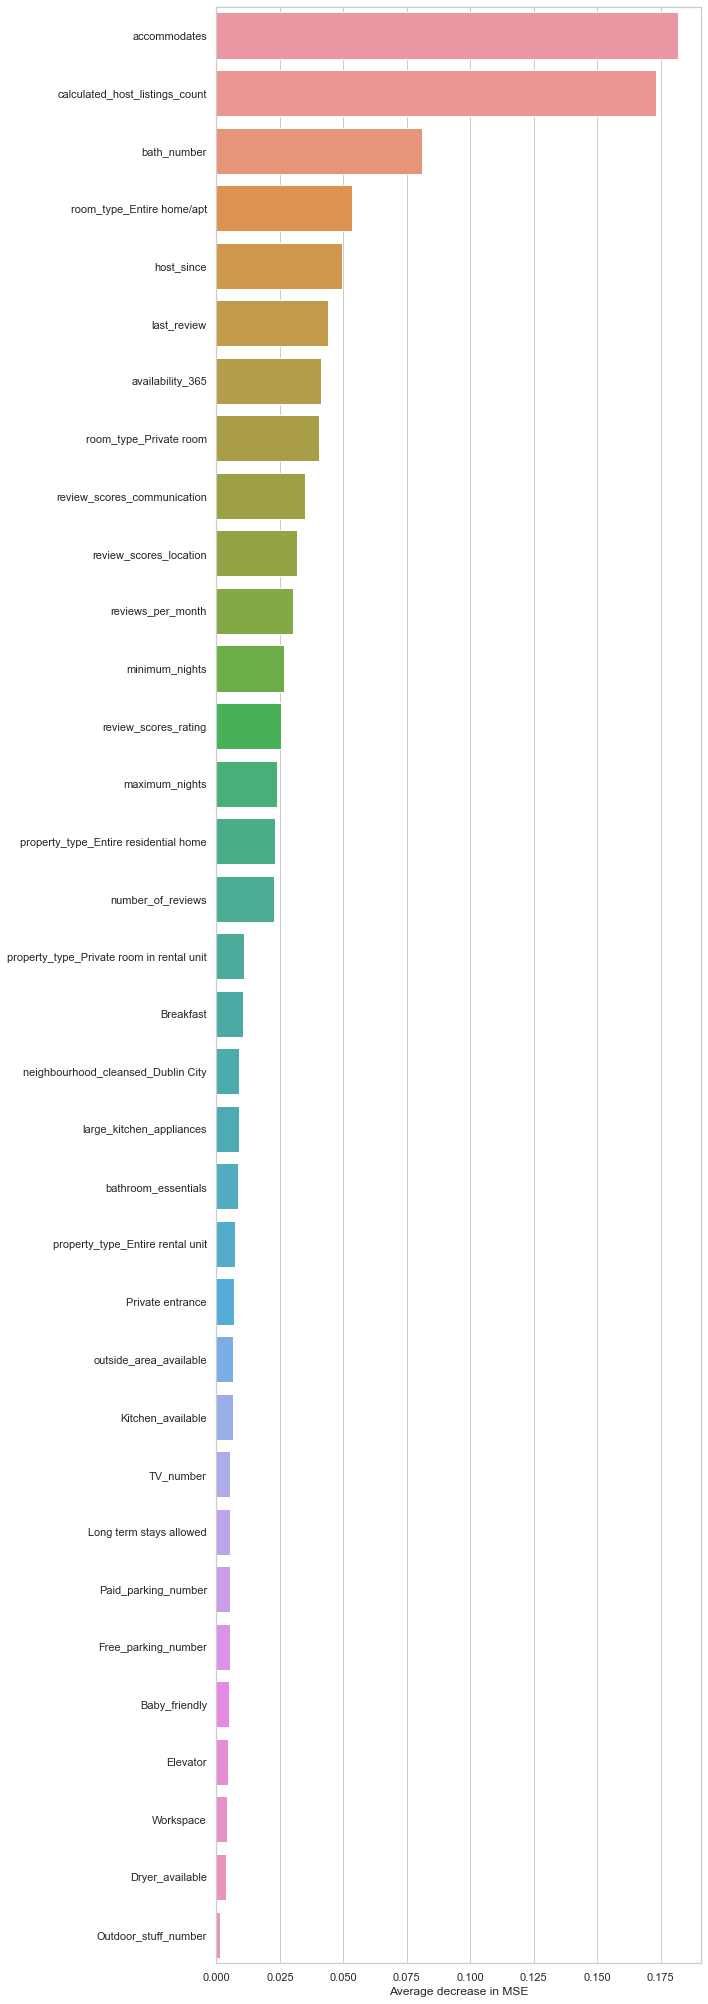

In [243]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation
Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

### Permutation approach

In [246]:
n_repeats = 10

In [247]:
result = permutation_importance(forest, X_test, y_test, n_repeats = n_repeats, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/2623107921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## Linear Regression

In [248]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.1794506533888648

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/2182281270.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


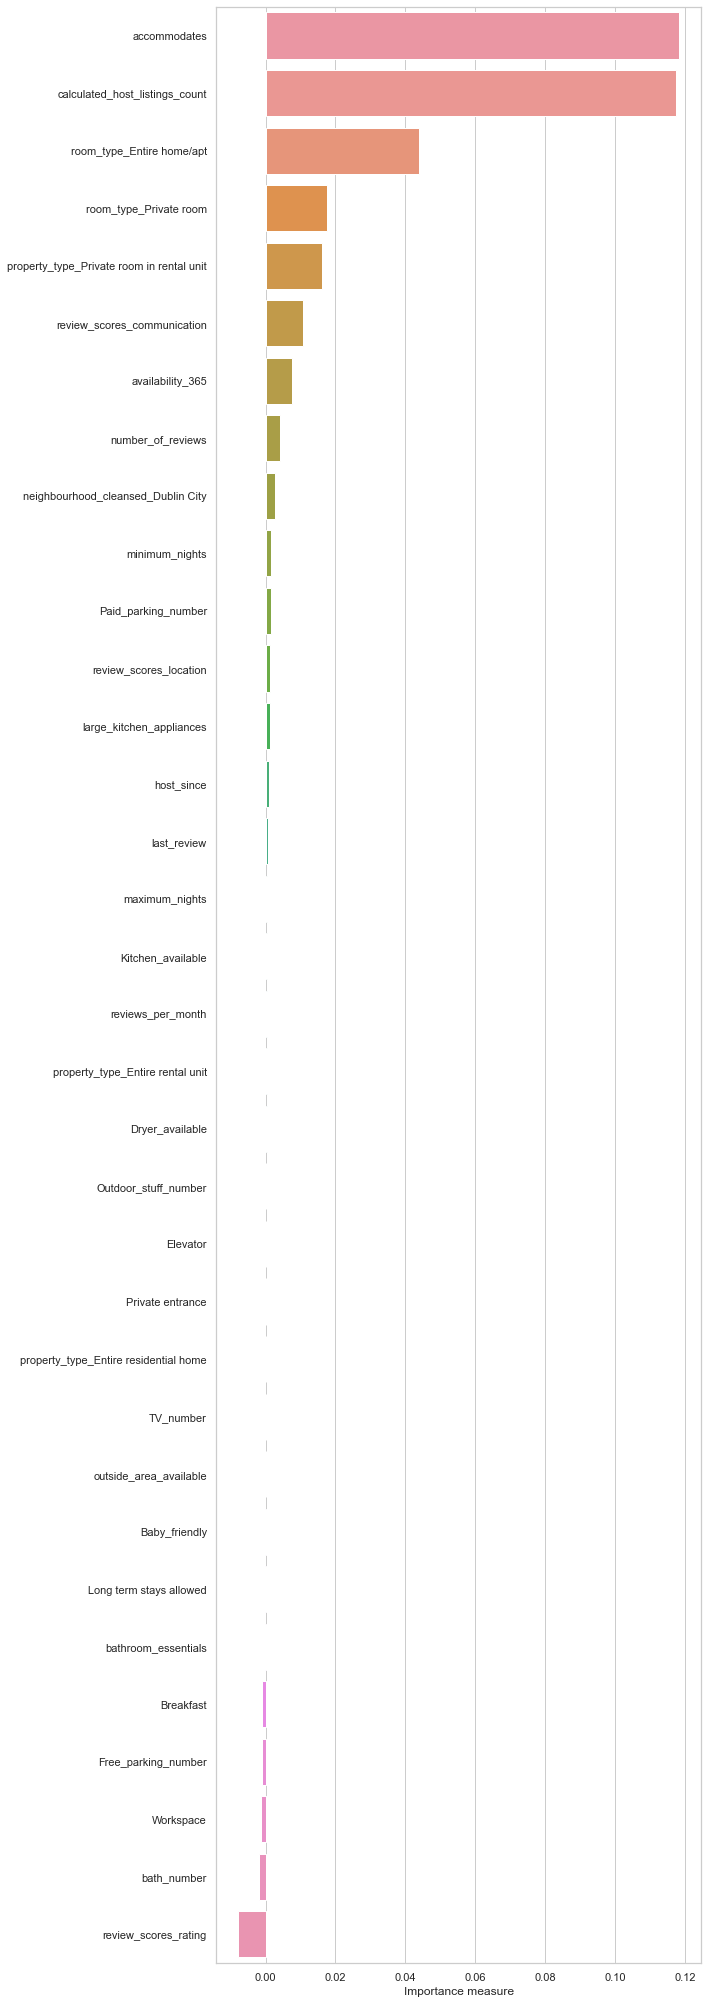

In [249]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42)
lm_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = lm_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Ridge with Kernel model
Let's repeat the permutation approach for several other algorithms

### rbf kernel

In [250]:
# train Ridge Kernel model
rbf_ridge = KernelRidge(kernel = "rbf", alpha = 0)
rbf_ridge.fit(X_train, y_train)
rbf_ridge.score(X_test, y_test)

-0.1493828234307757

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/2830413365.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


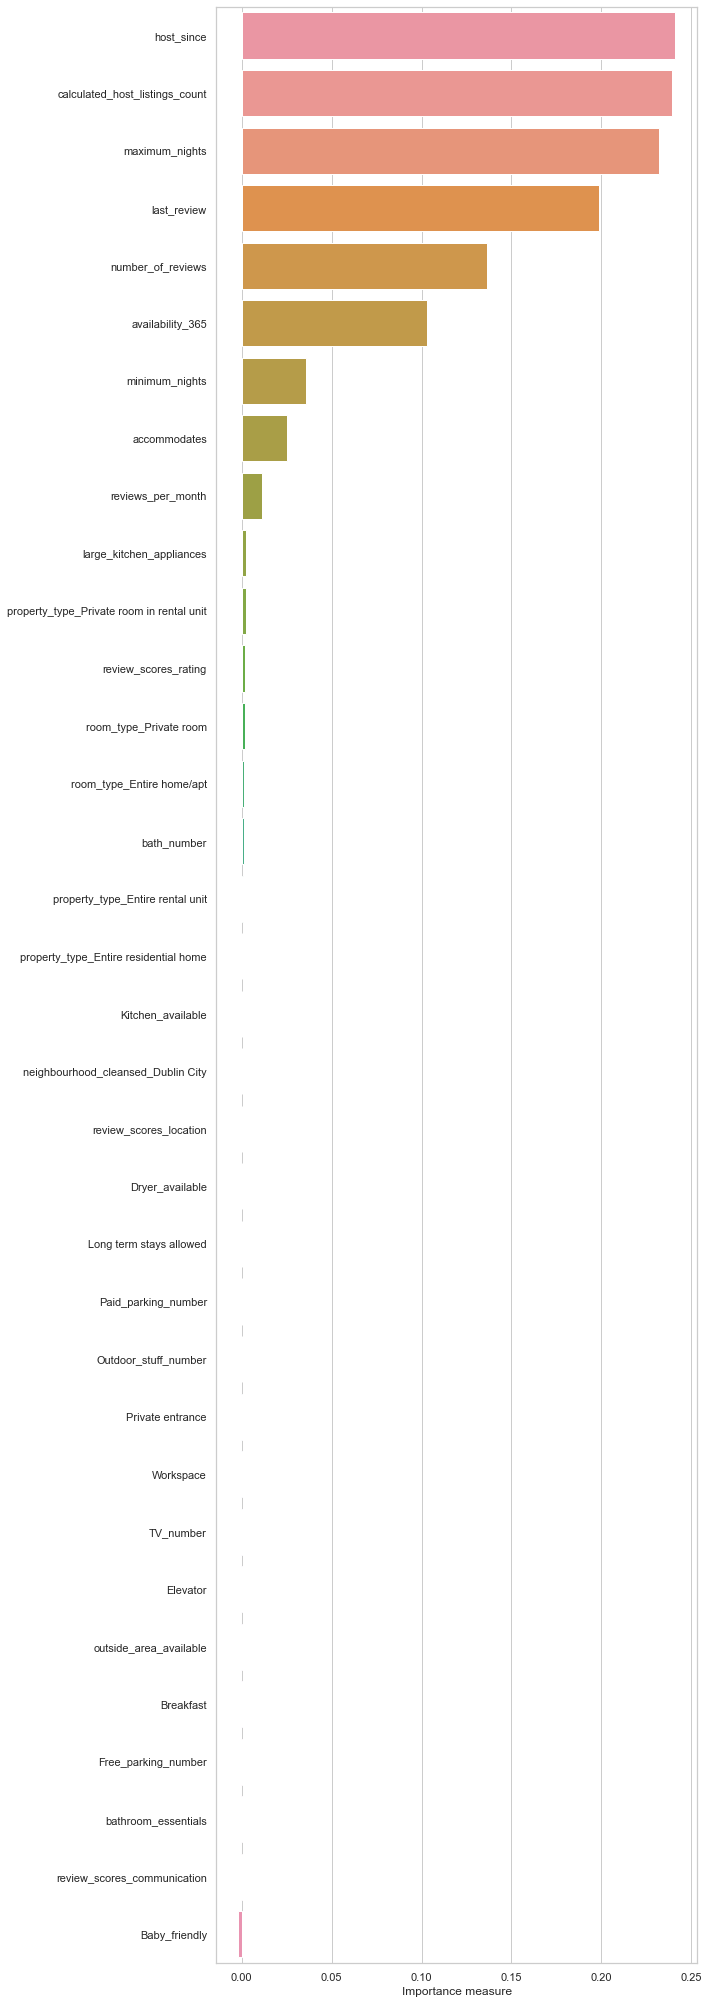

In [251]:
result = permutation_importance(rbf_ridge, X_test, y_test, n_repeats=n_repeats, random_state=42)
rbf_ridge_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = rbf_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

### linear kernel

In [252]:
# train Ridge Kernel model
linear_ridge = KernelRidge(kernel = "linear")
linear_ridge.fit(X_train, y_train)
linear_ridge.score(X_test, y_test)

0.17801224143427308

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/4222484363.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


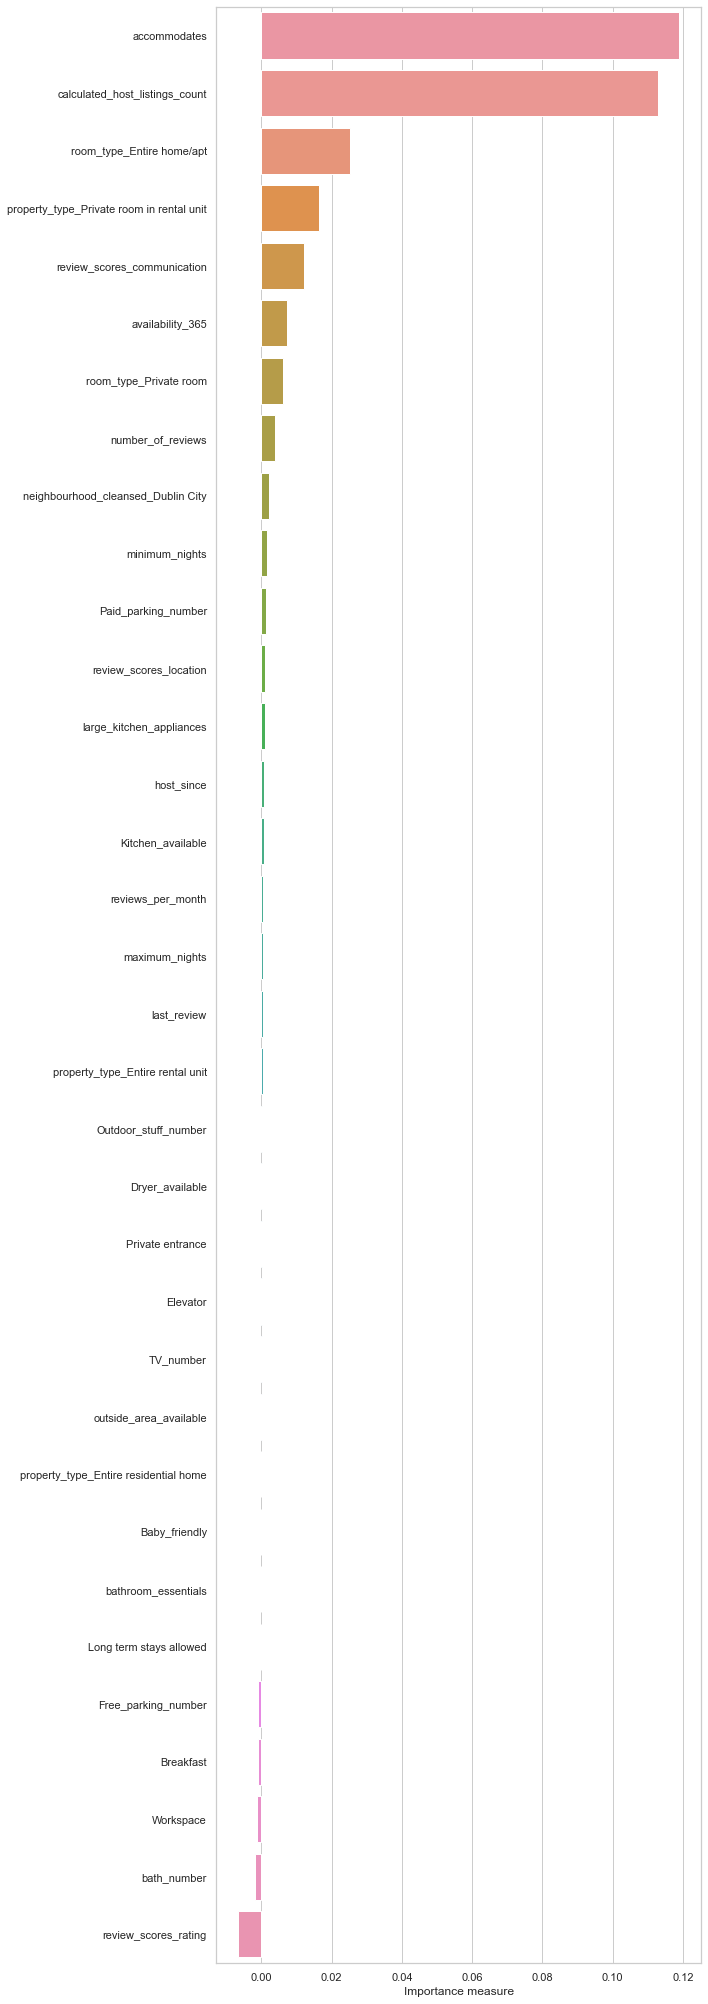

In [253]:
result = permutation_importance(linear_ridge, X_test, y_test, n_repeats=n_repeats, random_state=42)
linear_ridge_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = linear_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [194]:
params = {
    "n_estimators": 200,
    "max_depth": 2,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.6359934375748355

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_45588/1496711808.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


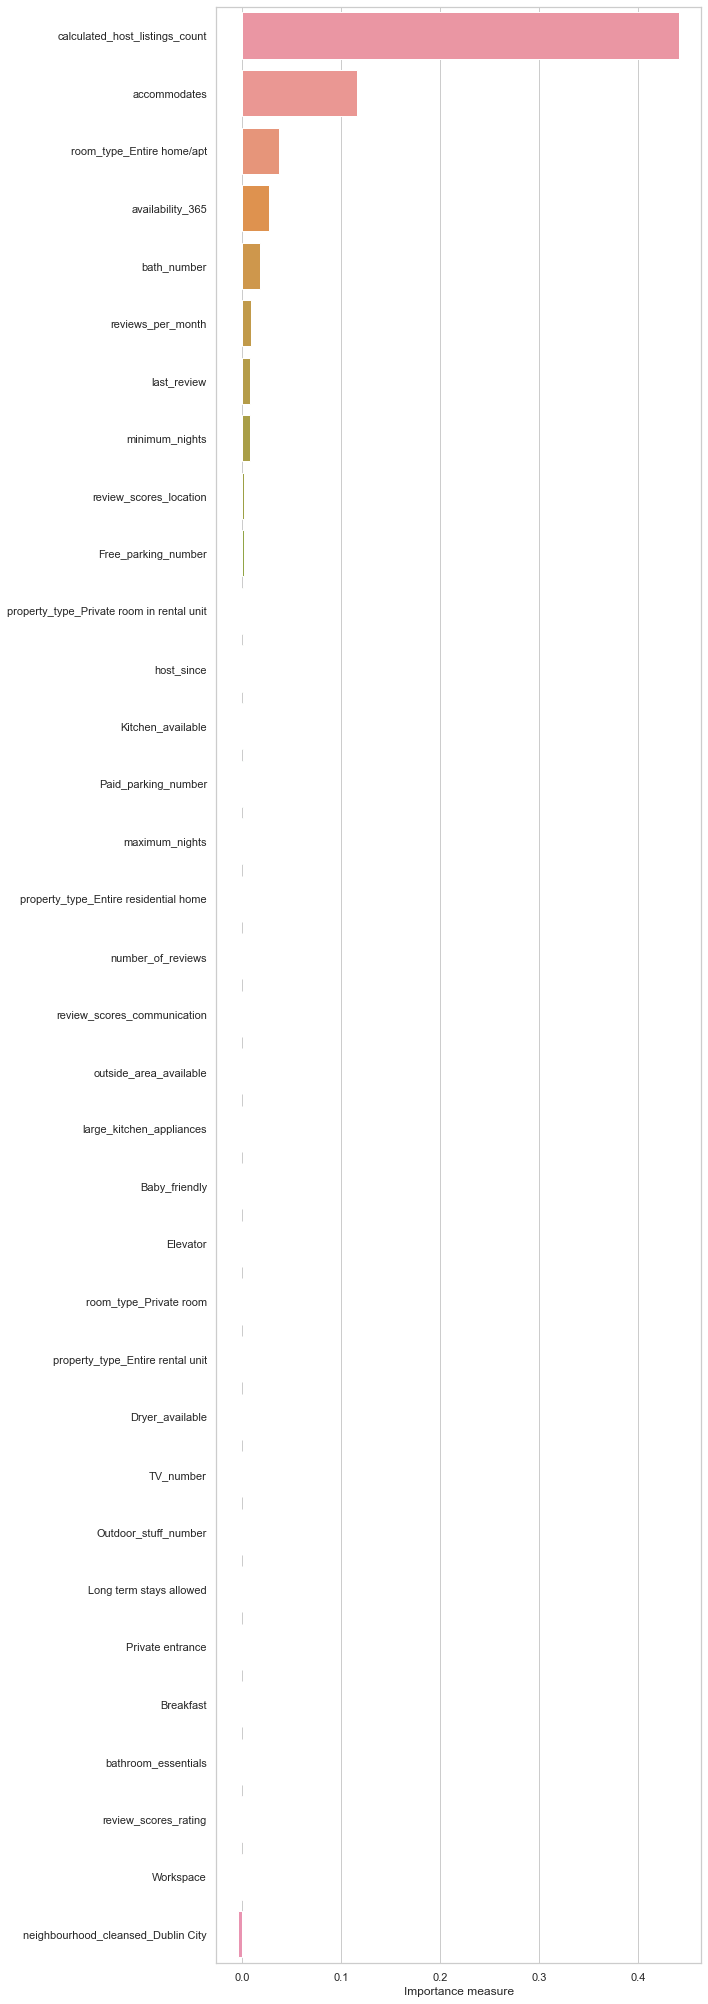

In [255]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42, scoring = "r2")
boost_feature_importance = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = boost_feature_importance.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

In [256]:
importances = pd.DataFrame({"Forest": forest_importances, "Linear Regression": lm_importances, "RBF Ridge": rbf_ridge_importances, "Linear Ridge": linear_ridge_importances, "Boosting": boost_feature_importance})

In [257]:
importances

Forest  Linear Regression  \
Breakfast                                 -0.000116          -0.001028   
Elevator                                   0.000870           0.000143   
Long term stays allowed                    0.000303          -0.000123   
Private entrance                           0.000243           0.000094   
Workspace                                 -0.000827          -0.001216   
Dryer_available                           -0.000256           0.000263   
Kitchen_available                          0.001844           0.000516   
neighbourhood_cleansed_Dublin City        -0.000204           0.002655   
property_type_Entire rental unit           0.002782           0.000483   
property_type_Entire residential home      0.005776           0.000091   
property_type_Private room in rental unit  0.011711           0.016094   
room_type_Entire home/apt                  0.041135           0.043950   
room_type_Private room                     0.022788           0.017451   
host_since                                 0.010830           0.000947   
accommodates                               0.054548           0.118413   
minimum_nights                             0.012681           0.001646   
maximum_nights                             0.007562           0.000517   
availability_365                           0.018932           0.007669   
number_of_reviews                          0.006723           0.004042   
last_review                                0.008262           0.000775   
review_scores_rating                       0.003224          -0.007763   
review_scores_communication                0.002482           0.010817   
review_scores_location                     0.002466           0.001395   
calculated_host_listings_count             0.222727           0.117467   
reviews_per_month                          0.003656           0.000508   
bath_number                                0.013346          -0.001785   
TV_number                                  0.000219           0.000077   
Outdoor_stuff_number                      -0.000055           0.000203   
Baby_friendly                             -0.000105          -0.000038   
Free_parking_number                        0.000913          -0.001066   
Paid_parking_number                        0.003787           0.001414   
bathroom_essentials                       -0.000394          -0.000138   
large_kitchen_appliances                   0.000701           0.001345   
outside_area_available                    -0.000088          -0.000009   

                                           RBF Ridge  Linear Ridge  Boosting  
Breakfast                                  -0.000265     -0.000977 -0.000127  
Elevator                                   -0.000149      0.000089  0.000000  
Long term stays allowed                     0.000120     -0.000076  0.000000  
Private entrance                           -0.000038      0.000115 -0.000015  
Workspace                                  -0.000057     -0.001119 -0.000846  
Dryer_available                             0.000268      0.000197  0.000000  
Kitchen_available                           0.000474      0.000656  0.000716  
neighbourhood_cleansed_Dublin City          0.000451      0.002227 -0.003572  
property_type_Entire rental unit            0.000709      0.000419  0.000000  
property_type_Entire residential home       0.000487      0.000025  0.000328  
property_type_Private room in rental unit   0.002266      0.016310  0.000906  
room_type_Entire home/apt                   0.001591      0.025113  0.037309  
room_type_Private room                      0.001669      0.006222  0.000000  
host_since                                  0.241112      0.000807  0.000879  
accommodates                                0.025212      0.118985  0.116013  
minimum_nights                              0.035884      0.001632  0.007593  
maximum_nights                              0.231972      0.000546  0.000544  
availability_365                

In [258]:
importances.mean(axis = 1).sort_values(ascending=False)

calculated_host_listings_count               0.226762
accommodates                                 0.086634
host_since                                   0.050915
maximum_nights                               0.048228
last_review                                  0.043211
availability_365                             0.032786
number_of_reviews                            0.030327
room_type_Entire home/apt                    0.029820
minimum_nights                               0.011887
room_type_Private room                       0.009626
property_type_Private room in rental unit    0.009458
bath_number                                  0.005794
review_scores_communication                  0.005015
reviews_per_month                            0.004918
review_scores_location                       0.001436
Paid_parking_number                          0.001435
property_type_Entire residential home        0.001341
large_kitchen_appliances                     0.001176
property_type_Entire rental 